In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import funcionalidade as fc

In [2]:
inativos = pd.read_pickle('inativos_fatura_premiada.pkl')

In [3]:
cliques = pd.read_csv('export_retornos_infobip_fatura_turbinada.csv', usecols = ['to','send_at','opens','clicks'], parse_dates=['send_at'])

In [4]:
cliques.head()

,to,send_at,opens,clicks
0,leandrobarbosaa528@gmail.com,2023-03-23 10:45:54,NaN,NaN
1,gabriellareis.comercial@gmail.com,2023-03-23 10:45:22,NaN,NaN
2,hian.100@hotmail.com,2023-03-23 10:45:42,NaN,NaN
3,samag967@gmail.com,2023-03-17 12:38:38,NaN,NaN
4,jefersomnunes39@gmail.com,2023-03-23 10:50:40,NaN,NaN


In [5]:
len(cliques)

5391143

In [6]:
cliques['opens'].sum()

1024282.0

In [7]:
cliques['clicks'].sum()

80135.0

In [8]:
cliques['opens'] = cliques['opens'].fillna(0.0)
cliques['clicks'] = cliques['clicks'].fillna(0.0)

In [9]:
cliques = cliques.groupby('to').agg({'opens':['max'],'clicks':['max'],'send_at':['min', 'max'] })
cliques.columns = cliques.columns.droplevel(0)
cliques = cliques.reset_index()
cliques.head()

,to,max,max,min,max
0,0.9martinsmariana@gmail.com,1.0,0.0,2023-03-17 13:02:41,2023-03-30 14:24:44
1,0.9pollyane9798@gmail.com,0.0,0.0,2023-03-17 12:53:47,2023-03-30 14:21:39
2,0.notbook.0@gmail.com,1.0,0.0,2023-03-17 13:02:51,2023-03-30 14:24:48
3,00.willian@gmail.com,0.0,0.0,2023-03-17 12:53:37,2023-03-30 14:21:26
4,000.azmildo@gmail.com,0.0,0.0,2023-03-17 13:02:55,2023-03-30 14:24:40


In [10]:
cliques.columns = ['to', 'opens', 'clicks', 'send_at_min', 'send_at_max']
cliques.head()

,to,opens,clicks,send_at_min,send_at_max
0,0.9martinsmariana@gmail.com,1.0,0.0,2023-03-17 13:02:41,2023-03-30 14:24:44
1,0.9pollyane9798@gmail.com,0.0,0.0,2023-03-17 12:53:47,2023-03-30 14:21:39
2,0.notbook.0@gmail.com,1.0,0.0,2023-03-17 13:02:51,2023-03-30 14:24:48
3,00.willian@gmail.com,0.0,0.0,2023-03-17 12:53:37,2023-03-30 14:21:26
4,000.azmildo@gmail.com,0.0,0.0,2023-03-17 13:02:55,2023-03-30 14:24:40


In [11]:
#inativos.to_csv('inativos_fatura_premiada.csv')

In [12]:
inativos['grupo_comunicacao'].value_counts()

Comunicação MCC         732744
Comunicação Genérica     95054
Sem comunicação          88540
Name: grupo_comunicacao, dtype: int64

In [13]:
inativos['grupo_comunicacao'].value_counts()

Comunicação MCC         732744
Comunicação Genérica     95054
Sem comunicação          88540
Name: grupo_comunicacao, dtype: int64

### Trazendo conversão

In [14]:
inativos_v1_c = fc.traz_conversao('flavia-costa', '2023-03-17', '2023-03-24', 'cpf', inativos)

In [15]:
len(inativos_v1_c)

916338

In [16]:
inativos_v1_c['converteu'].value_counts()

0.0    854320
1.0     62018
Name: converteu, dtype: int64

### Traz personas

In [17]:
import acessos as ac

In [18]:
personas = ac.df_athena_q('flavia-costa', 
                          """    select *, 
                              date_diff('day', cast(ultima_data as date), to_date('2023-03-17', 'yyyy-mm-dd')) as recencia
                              from (
                              select ci.cpf
                              , max(ds_cluster_sociodemographic) as ds_cluster_sociodemographic
                              , max(email) as to
                              , max(sp.dt_dia) as ultima_data
                              from customer_curated_zone.ca_book_cliente_cluster cl
                              left join customer_curated_zone.ca_book_cliente ci on (ci.id_customer = cl.id_customer)
                              left join growth_curated_zone.clientes gc on (gc.cpf = ci.cpf)
                              left join platform_curated_zone.transaction_dedicada_spending sp on (sp.cpf = ci.cpf and sp.dt_data < to_date('2023-03-17','yyyy-mm-dd'))
                              group by 1   )                           
                                """)

inativos_v1_p1 = inativos_v1_c.join(personas.set_index('cpf'), how = 'left', on = 'cpf')

In [19]:
inativos_v1_p = inativos_v1_p1.join(cliques.set_index('to'), how = 'left', on = 'to')

In [20]:
inativos_v1_p['recencia'].fillna(inativos_v1_p['recencia'].max(), inplace = True)
inativos_v1_p['ds_cluster_sociodemographic'].fillna(inativos_v1_p['ds_cluster_sociodemographic'].mode()[0], inplace = True)

In [21]:
limite_disp = ac.df_athena_q('flavia-costa', 
                          """with base_limite_diaria as (
                                    select
                                    dt_data
                                    , cpf
                                    , limite
                                    , (limite - utilizado) as limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_will
                                    where dt_data < to_date('2023-03-17','yyyy-mm-dd')
                                    union all
                                    select
                                    dt_movimentacao as dt_data 
                                    , cpf 
                                    , limite
                                    , limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_pag
                                    where dt_movimentacao < to_date('2023-03-17','yyyy-mm-dd')
                                    )
                                    , base_lim_rankeada as (
                                    select *
                                    , row_number() over (partition by cpf order by cpf asc, dt_data desc, iu desc) as linha
                                    from base_limite_diaria
                                    )
                                    select 
                                    cpf
                                    , max(limite) as limite
                                    , min(limite_disponivel) as limite_disponivel
                                    , max(iu) as iu
                                    from base_lim_rankeada
                                    where linha = 1
                                    group by 1 """)

inativos_v1_p = inativos_v1_p.join(limite_disp.set_index('cpf'), how = 'left', on = 'cpf')

In [22]:
inativos_v1_p['opens'] = inativos_v1_p['opens'].fillna(0.0)
inativos_v1_p['clicks'] = inativos_v1_p['clicks'].fillna(0.0)
inativos_v1_p = inativos_v1_p.replace([np.inf, -np.inf], 0)

### Análises de Lift

In [23]:
inativos_v1_p.to_pickle('inativos_v2_conversao.pkl')

In [24]:
inativos_v1_p = pd.read_pickle('inativos_v2_conversao.pkl')

In [25]:
inativos_v1_p.head()

,cpf,grupo_comunicacao,segmento_mcc_agg,nr_score_ie,yearmonth_ie,status,safra,conta_cartao,converteu,transacoes,...,to,ultima_data,recencia,opens,clicks,send_at_min,send_at_max,limite,limite_disponivel,iu
0,13364903735,Comunicação Genérica,1 - SUPERMERCADO,NaN,202302.0,Inativo,2021-03-01,NaN,0.0,NaN,...,alexgaigherdepaula@hotmail.com,2023-02-08,37.0,0.0,0.0,NaT,NaT,540.0,348.50,0.35
1,60598266364,Comunicação Genérica,1 - SUPERMERCADO,NaN,202302.0,Inativo,2021-03-01,49560640.0,1.0,4.0,...,vanusiapereira313@gmail.com,2023-03-08,9.0,0.0,0.0,NaT,NaT,2400.0,1599.82,0.33
2,86127770548,Comunicação Genérica,1 - SUPERMERCADO,8.426771,202302.0,Inativo,2019-04-01,NaN,0.0,NaN,...,alissonpcm38@gmail.com,2022-09-29,169.0,0.0,0.0,NaT,NaT,1200.0,1198.94,0.00
3,36464411861,Comunicação Genérica,1 - SUPERMERCADO,NaN,202302.0,Inativo,2021-04-01,50217070.0,1.0,2.0,...,ygoralves521@gmail.com,2023-03-04,13.0,0.0,0.0,NaT,NaT,900.0,241.32,0.73
4,07862470370,Comunicação Genérica,1 - SUPERMERCADO,77.535854,202302.0,Inativo,2021-10-01,52711980.0,1.0,1.0,...,douglasholandadoglas867@gmail.com,2022-10-02,166.0,0.0,0.0,NaT,NaT,800.0,-52.11,1.07


Análise reduzida geral

In [27]:
inativos_v1_p.columns

Index(['cpf', 'grupo_comunicacao', 'segmento_mcc_agg', 'nr_score_ie',
       'yearmonth_ie', 'status', 'safra', 'conta_cartao', 'converteu',
       'transacoes', 'spending', 'spending_corr', 'transacoes_corr', 'to',
       'ds_cluster_sociodemographic', 'opens', 'clicks', 'send_at_min',
       'send_at_max', 'limite', 'limite_disponivel', 'iu'],
      dtype='object')

In [26]:
inativos_v1_p['flag_opens'] = np.where(inativos_v1_p['opens'] >= 1, 1, 0)
inativos_v1_p['cluster_persona'] = inativos_v1_p['ds_cluster_sociodemographic'].str[0:2]

In [27]:
inativos_v1_p['grupo'] = ['controle' if x == 'Sem comunicação' else 'alvo' for x in inativos_v1_p['grupo_comunicacao']]

In [31]:
inativos_v1_p[['converteu','grupo', 'flag_opens']].groupby(['grupo', 'flag_opens']).mean()

converteu
grupo    flag_opens           
alvo     0            0.066919
         1            0.145692
controle 0            0.069905
         1            0.120879

In [32]:
inativos_v1_p[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.067437
controle,0.069957


In [55]:
inativos_v1_p[['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,827798
controle,88540


In [33]:
inativos_v1_p.query('opens >= 1 | grupo == "controle"')[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.145692
controle,0.069957


In [35]:
inativos_v1_p \
.query('nr_score_ie >6.78') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.103578
controle,0.101956


In [45]:
inativos_v1_p \
.query('nr_score_ie >6.78 & nr_score_ie <=27.15') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.096867
controle,0.093943


In [56]:
inativos_v1_p \
.query('nr_score_ie >6.78') \
[['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,126774
controle,14212


In [36]:
inativos_v1_p.query('nr_score_ie >6.78') \
.query('opens >= 1 | grupo == "controle"') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.124969
controle,0.101956


In [46]:
inativos_v1_p \
.query('nr_score_ie >6.78 & nr_score_ie <=27.15') \
    .query('opens >= 1 | grupo == "controle"') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.118243
controle,0.093943


In [37]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('cluster_persona == "12" | cluster_persona == "13" | cluster_persona == "14"| cluster_persona == "15"') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.069314
controle,0.069095


In [57]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('cluster_persona == "12" | cluster_persona == "13" | cluster_persona == "14"| cluster_persona == "15"') \
[['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,114334
controle,12244


In [38]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('opens >= 1 | grupo == "controle"') \
.query('cluster_persona == "12" | cluster_persona == "13" | cluster_persona == "14"| cluster_persona == "15"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.153846
controle,0.069095


In [44]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('recencia > 241') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.030465
controle,0.032494


In [43]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('recencia > 241') \
    .query('opens >= 1 | grupo == "controle"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.040000
controle,0.032494


In [53]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('ds_cluster_sociodemographic == "0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.080064
controle,0.089014


In [54]:
inativos_v1_p[inativos_v1_p['ds_cluster_sociodemographic'].isna() == False]  \
.query('opens >= 1 | grupo == "controle"') \
.query('ds_cluster_sociodemographic == "0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.140909
controle,0.089014


In [47]:
inativos_v1_p \
.query('limite < 600') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.201552
controle,0.192176


In [48]:
inativos_v1_p \
.query('limite < 600') \
    .query('opens >= 1 | grupo == "controle"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.220690
controle,0.192176


In [52]:
inativos_v1_p \
.query('limite < 600') \
    [['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,78724
controle,8794


In [49]:
inativos_v1_p \
.query('limite_disponivel < 600') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.178983
controle,0.171791


In [50]:
inativos_v1_p \
.query('limite_disponivel < 600') \
    .query('opens >= 1 | grupo == "controle"') \
    [['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.176555
controle,0.171791


In [54]:
inativos_v1_p.pivot_table(index = 'ds_cluster_sociodemographic', columns= 'segmento_mcc_agg', values = 'converteu', aggfunc=np.mean)

segmento_mcc_agg,0 - OUTROS,1 - SUPERMERCADO,2 - LOJAS DE DEPARTAMENTO,3 - SERVICOS DE ALIMENTACAO,4 - SAUDE,5 - LOJAS ESPECIALIZADAS
ds_cluster_sociodemographic,,,,,,
"0 - Mulher, Casada, 25 anos ou mais, cidade Pe...",0.080523,0.285714,0.230769,0.100000,0.500000,0.181818
"1 - Mulher, Solteira, Até 24 anos, cidade Médi...",0.079751,0.500000,0.666667,0.500000,0.400000,0.250000
"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",0.105710,0.100000,0.400000,0.166667,0.333333,0.181818
"11 - Homem, Solteiro, Até 24 anos, cidade Pequ...",0.087870,0.333333,0.222222,0.125000,0.400000,0.214286
"12 - Mulher, Solteira, 35 anos ou mais, cidade...",0.082804,0.666667,0.285714,NaN,0.500000,0.238095
"13 - Homem, Solteiro, 35 anos ou mais, cidade ...",0.065306,0.000000,1.000000,0.000000,NaN,NaN
"14 - Homem, Casado, 35 anos ou mais, cidade Pe...",0.081242,0.000000,0.166667,0.666667,0.500000,0.000000
"15 - Mulher, 25 a 40 anos, Nordeste",0.068086,0.380952,0.363636,0.314286,0.472222,0.129032
"16 - Homem, 25 a 40 anos, Nordeste",0.057969,0.150000,0.500000,0.297297,0.387097,0.228571


In [39]:
inativos_v1_p['fx_iu'] = pd.qcut(inativos_v1_p['iu'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
inativos_v1_p['fx_limite'] = pd.qcut(inativos_v1_p['limite'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
inativos_v1_p['fx_limite_disponivel'] = pd.qcut(inativos_v1_p['limite_disponivel'].rank(method='first'), q=10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])

In [64]:
fc.testes_iterativos(inativos_v1_p.query('opens >= 1 | grupo == "controle"'))

          grupo converteu    spending             transacoes         
          count      mean        mean         sum       mean      sum
grupo                                                                
alvo       5443  0.145692  602.413266   477713.72   2.534678   2010.0
controle  88540  0.069957  389.229104  2410885.07   2.827091  17511.0
_____________________
Lift da conversão: 108.26%
Estatística t do teste de diferença de proporções: 20.72
P-valor do teste de diferença de proporções: 0.0
Conclusão:
A diferença de conversão é estatisticamente significativa
______________________________________________________________
Lift do spending: 54.77%
Estatística t do teste de spending: 15.62
P-valor do teste de spending: 0.0
Conclusão:
A diferença de spending é estatisticamente significativa
______________________________________________________________
Lift da frequência: -10.34%
Estatística t do teste de frequencia: 11.27
P-valor do teste de frequencia: 0.0
A diferença de frequênc

In [40]:
inativos_v1_p[['converteu','grupo', 'fx_limite']].groupby(['grupo','fx_limite']).mean()

converteu
grupo    fx_limite           
alvo     1           0.206397
         2           0.201106
         3           0.195162
         4           0.102714
         5           0.111773
         6           0.104141
         7           0.109623
         8           0.132597
         9           0.095360
         10          0.089211
controle 1           0.000000
         2           0.207080
         3           0.205330
         4           0.103678
         5           0.120939
         6           0.107084
         7           0.113928
         8           0.112763
         9           0.121685
         10          0.091830

In [41]:
inativos_v1_p[['converteu','grupo', 'fx_limite_disponivel']].groupby(['grupo','fx_limite_disponivel']).mean()

converteu
grupo    fx_limite_disponivel           
alvo     1                      0.045982
         2                      0.308133
         3                      0.179356
         4                      0.183543
         5                      0.103739
         6                      0.113399
         7                      0.109795
         8                      0.122676
         9                      0.101347
         10                     0.081336
controle 1                      0.046117
         2                      0.299865
         3                      0.172306
         4                      0.168300
         5                      0.119870
         6                      0.115986
         7                      0.106891
         8                      0.125869
         9                      0.109169
         10                     0.084935

In [42]:
inativos_v1_p[['converteu','grupo', 'fx_iu']].groupby(['grupo','fx_iu']).mean()

converteu
grupo    fx_iu           
alvo     1       0.050637
         2       0.042790
         3       0.046202
         4       0.049709
         5       0.154510
         6       0.197855
         7       0.255631
         8       0.282578
         9       0.257305
         10      0.052682
controle 1       0.053333
         2            NaN
         3            NaN
         4       0.045662
         5       0.060587
         6       0.199196
         7       0.246276
         8       0.274101
         9       0.276119
         10      0.056720

In [43]:
inativos_v1_p[['fx_iu', 'iu']].groupby('fx_iu').agg({'iu':['min', 'max']})

iu         
           min      max
fx_iu                  
1     -1144.76     0.00
2         0.00     0.00
3         0.00     0.00
4         0.00     0.00
5         0.00     0.04
6         0.04     0.10
7         0.10     0.24
8         0.24     0.57
9         0.57     1.00
10        1.00  2121.48

In [45]:
len(inativos_v1_p.query('iu >0 & iu <=0.57'))

106294

In [59]:
inativos_v1_p.query('iu >0 & iu <=0.57') \
[['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,95724
controle,10570


In [48]:
inativos_v1_p.query('iu >0 & iu <=0.57') \
.query('opens >= 1 | grupo == "controle"') \
[['converteu','grupo']].groupby(['grupo']).mean()


,converteu
grupo,
alvo,0.196935
controle,0.228382


In [49]:
inativos_v1_p.query('iu >0 & iu <=0.57') \
.query('opens >= 1 | grupo == "controle"') \
[['converteu','grupo']].groupby(['grupo']).count()

,converteu
grupo,
alvo,2610
controle,10570


In [60]:
inativos_v1_p.columns

Index(['cpf', 'grupo_comunicacao', 'segmento_mcc_agg', 'nr_score_ie',
       'yearmonth_ie', 'status', 'safra', 'conta_cartao', 'converteu',
       'transacoes', 'spending', 'spending_corr', 'transacoes_corr', 'to',
       'ds_cluster_sociodemographic', 'opens', 'clicks', 'send_at_min',
       'send_at_max', 'limite', 'limite_disponivel', 'iu', 'flag_opens',
       'cluster_persona', 'grupo', 'fx_iu', 'fx_limite',
       'fx_limite_disponivel'],
      dtype='object')

In [61]:
inativos_v1_p[['converteu','grupo', 'segmento_mcc_agg']].groupby(['grupo','segmento_mcc_agg']).mean()

converteu
grupo    segmento_mcc_agg                      
alvo     0 - OUTROS                    0.067081
         1 - SUPERMERCADO              0.227468
         2 - LOJAS DE DEPARTAMENTO     0.330882
         3 - SERVICOS DE ALIMENTACAO   0.226115
         4 - SAUDE                     0.382114
         5 - LOJAS ESPECIALIZADAS      0.191398
controle 0 - OUTROS                    0.069472
         1 - SUPERMERCADO              0.352941
         2 - LOJAS DE DEPARTAMENTO     0.370370
         3 - SERVICOS DE ALIMENTACAO   0.290323
         4 - SAUDE                     0.384615
         5 - LOJAS ESPECIALIZADAS      0.254545

In [62]:
inativos_v1_p.query('segmento_mcc_agg == "4 - SAUDE"') \
[['converteu','grupo']].groupby(['grupo']).mean()


,converteu
grupo,
alvo,0.382114
controle,0.384615


In [63]:
inativos_v1_p.query('segmento_mcc_agg == "4 - SAUDE"') \
.query('opens >= 1 | grupo == "controle"') \
[['converteu','grupo']].groupby(['grupo']).mean()

,converteu
grupo,
alvo,0.222222
controle,0.384615


- Trazer recencia

In [28]:
from pylift import TransformedOutcome
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from optbinning import OptimalBinning
from optbinning import BinningProcess

(CVXPY) Apr 11 12:45:06 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 12:45:06 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


- Rodar Uplift

In [30]:
inativos_v1_p['flag_grupo'] = [0 if x == 'Sem comunicação' else 1 for x in inativos_v1_p['grupo_comunicacao']]

In [35]:
inativos_v1_p['ds_cluster_sociodemographic'] = np.where(inativos_v1_p['ds_cluster_sociodemographic'] == None, inativos_v1_p['ds_cluster_sociodemographic'].mode()[0], inativos_v1_p['ds_cluster_sociodemographic'])
inativos_v1_p['ds_cluster_sociodemographic'] = inativos_v1_p['ds_cluster_sociodemographic'].astype('string')
inativos_v1_p['cluster_persona'] = inativos_v1_p['ds_cluster_sociodemographic'].str[0:2]
inativos_v1_p['cluster_persona'] = inativos_v1_p['cluster_persona'].astype('int')
inativos_v1_p = inativos_v1_p.replace([np.inf, -np.inf], 0)

In [36]:
clf = LogisticRegression()

up = TransformedOutcome(inativos_v1_p[['flag_grupo', 'converteu', 'limite_disponivel', 'limite', 'iu', 'recencia',
                                                            'nr_score_ie','segmento_mcc_agg','cluster_persona']]
                        , col_treatment='flag_grupo', col_outcome='converteu', sklearn_model=LogisticRegression)

<AxesSubplot:xlabel='NIV', ylabel='Features'>

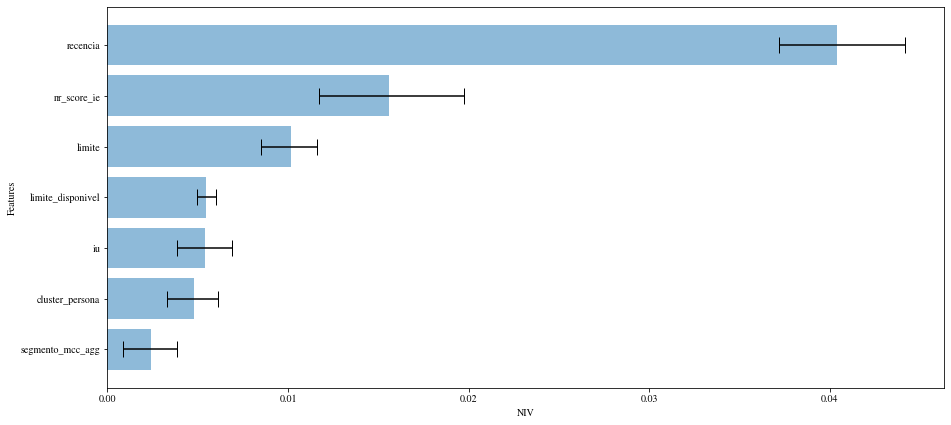

In [37]:
up.NIV()

<AxesSubplot:title={'center':'NWOE by bin for cluster_persona'}, xlabel='Bin Interval'>

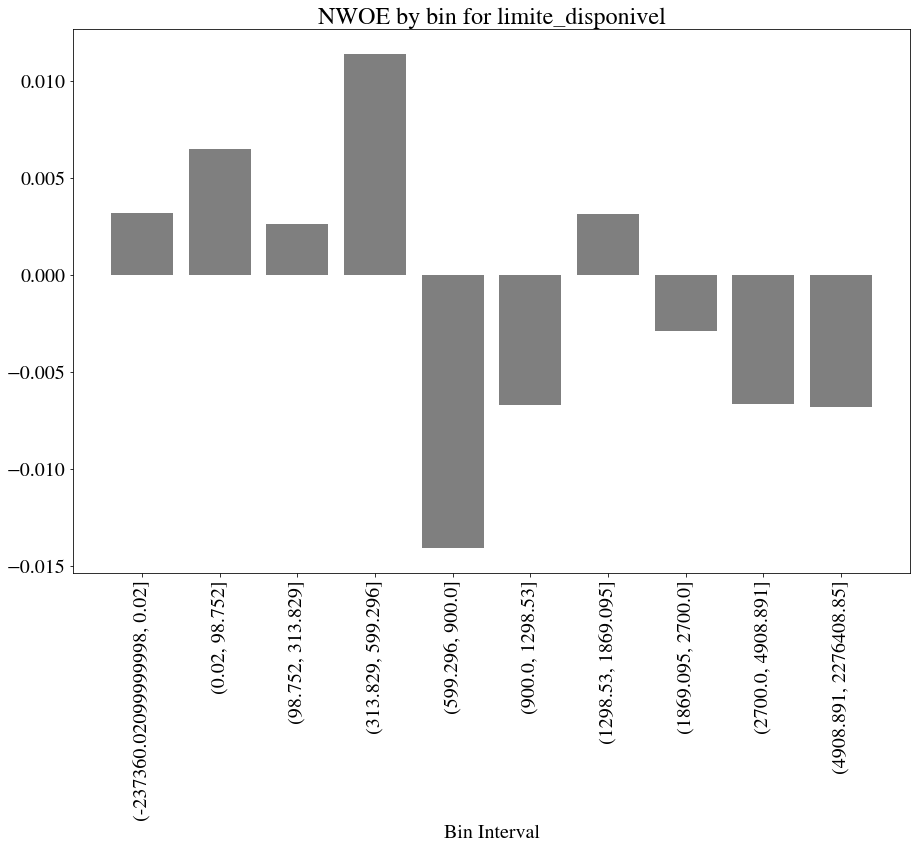

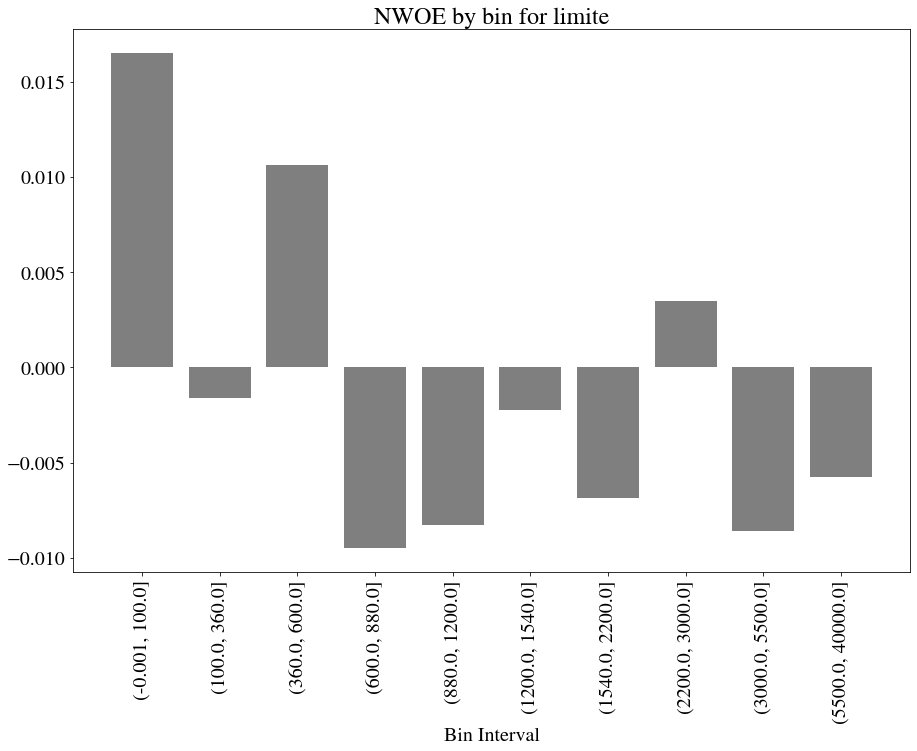

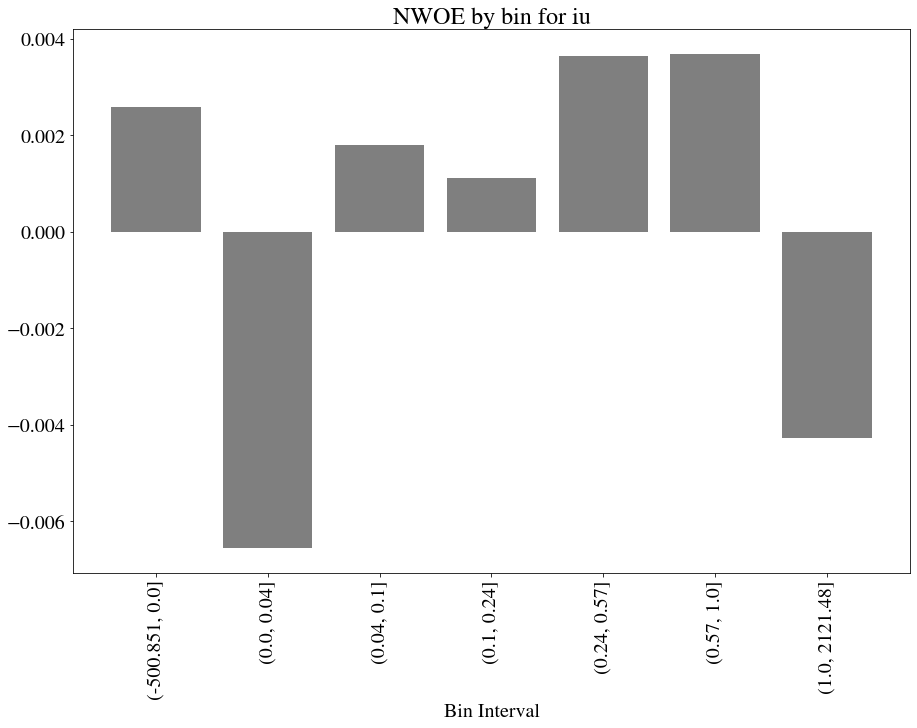

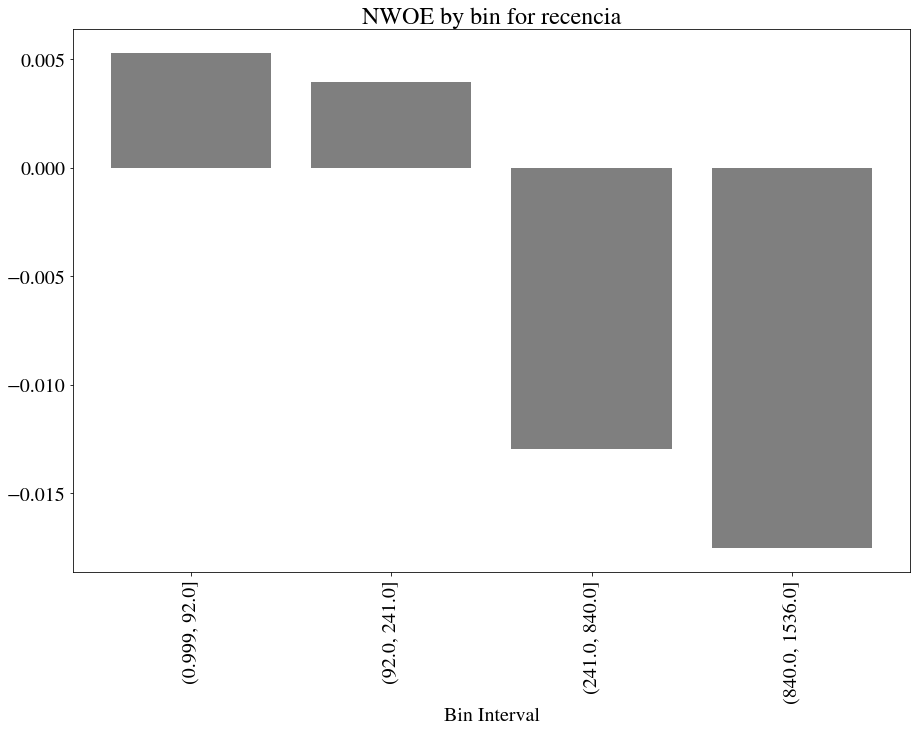

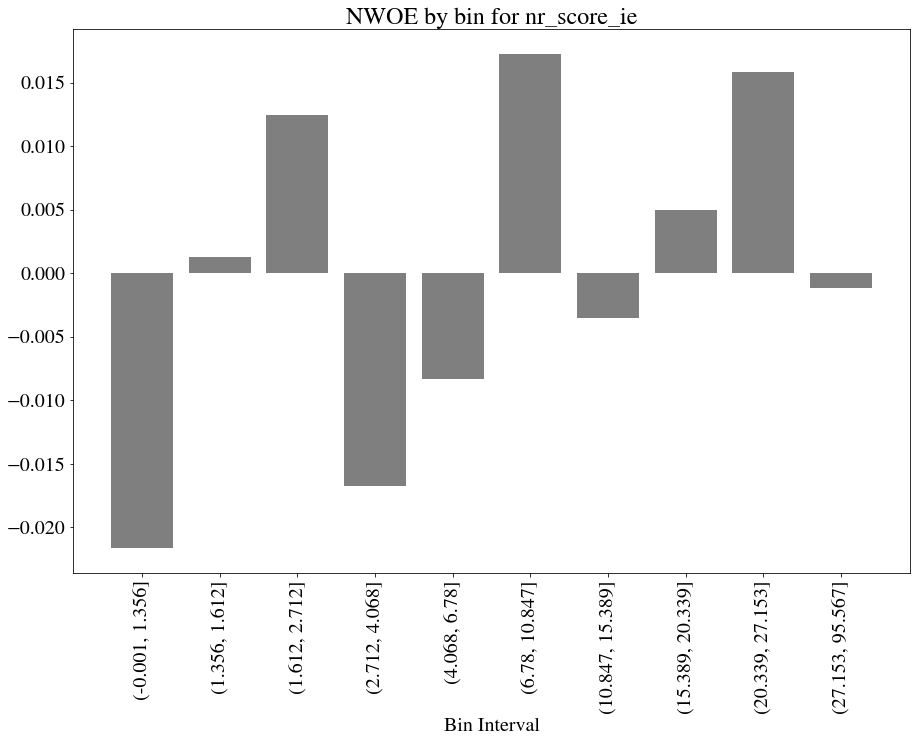

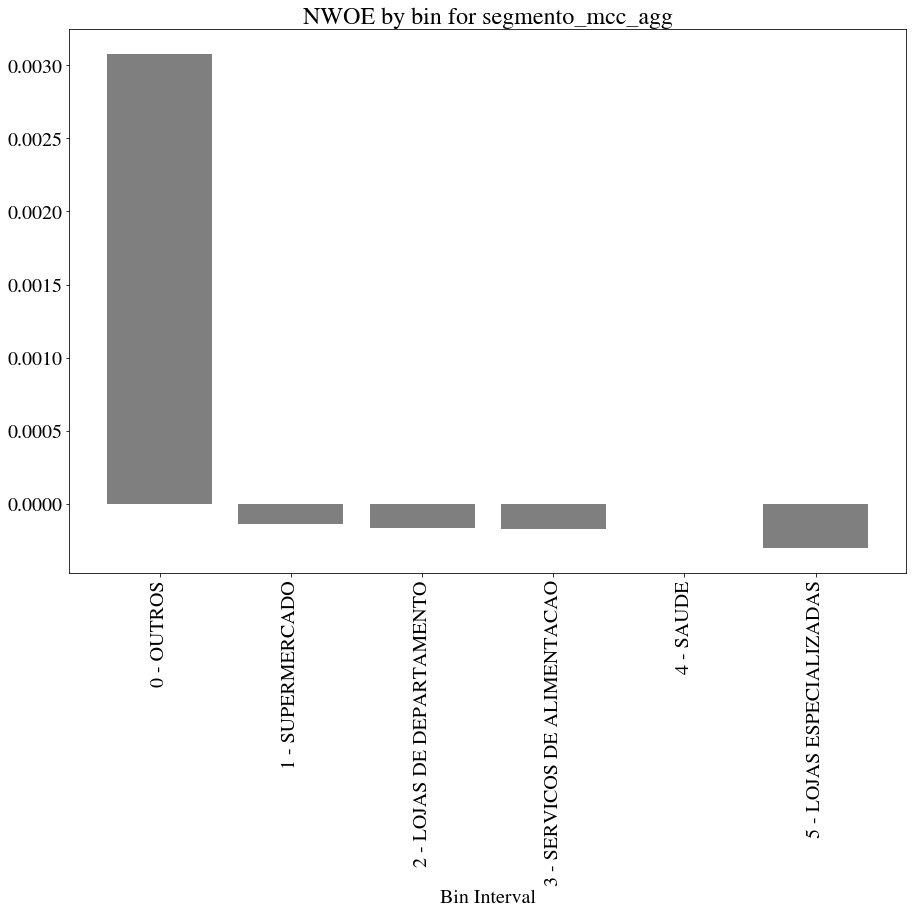

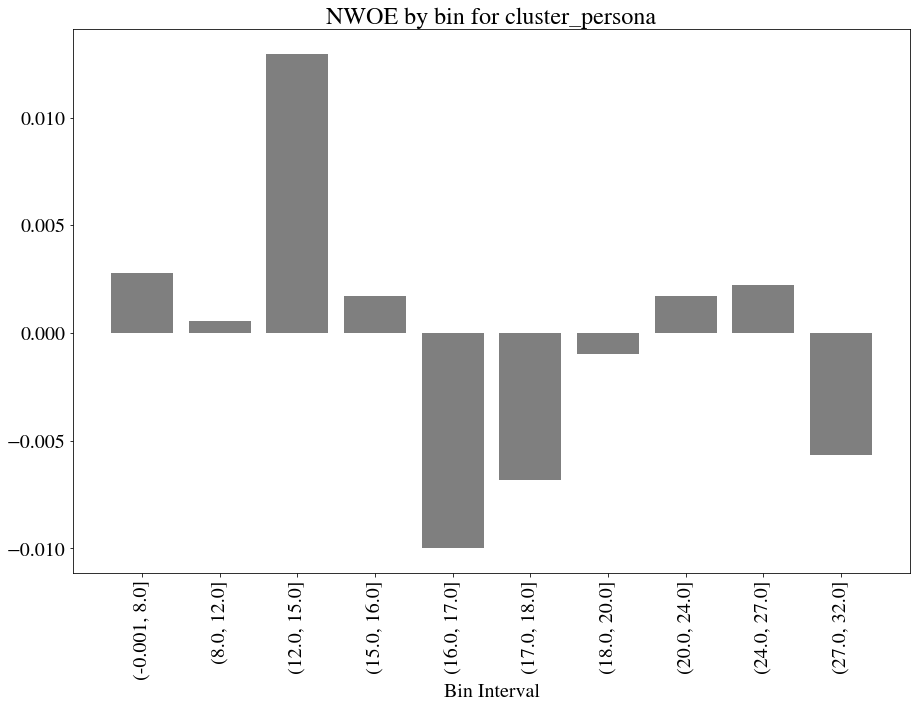

In [38]:
up.NWOE()